In [13]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

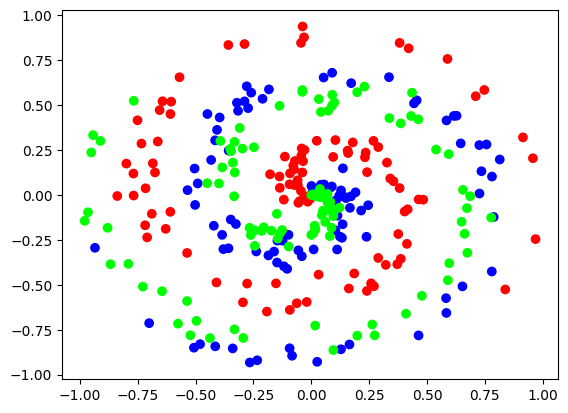

In [14]:
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [24]:
class layer_dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons , weight_regularizer_l1=0, weight_regularizer_l2=0, 
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [16]:
# ReLU activation
class activation_reLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.outputs = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [17]:
# Softmax activation
class softmax_act:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

In [18]:
# Common loss class
class Loss:
    # Regularization loss calculation
    def regularization_loss(self, layer):
        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # Calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        # Calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss

    
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

In [19]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [29]:

class activation_softmax_loss_categoricalcrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = softmax_act()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [21]:
# best optimizer: adam
class optimizer_adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7 , beta1=0.9 , beta2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

    def pre_update_parameters(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_parameters(self, layer):
        # Create momentum and cache arrays if they don't exist
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentums with current gradients
        layer.weight_momentums = self.beta1 * layer.weight_momentums + (1 - self.beta1) * layer.dweights
        layer.bias_momentums = self.beta1 * layer.bias_momentums + (1 - self.beta1) * layer.dbiases

        # Correct momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta1 ** (self.iterations + 1))

        # Update cache with squared gradients
        layer.weight_cache = self.beta2 * layer.weight_cache + (1 - self.beta2) * layer.dweights ** 2
        layer.bias_cache = self.beta2 * layer.bias_cache + (1 - self.beta2) * layer.dbiases ** 2

        # Correct cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        # Apply Adam update
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_parameters(self):
        self.iterations += 1
   

In [22]:
import numpy as np

class layer_dropout:
    def __init__(self,rate):
        self.rate = 1- rate
    def forward(self , inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate , size = inputs.shape) / self.rate
        # apply binary mask to output
        self.output = inputs * self.binary_mask
    def backward(self , dvalues):
        self.dinputs = dvalues*self.binary_mask

epoch: 0, acc: 0.282, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.616, loss: 0.883 (data_loss: 0.850, reg_loss: 0.033), lr: 0.04975371909050202
epoch: 200, acc: 0.656, loss: 0.815 (data_loss: 0.775, reg_loss: 0.040), lr: 0.049507401356502806
epoch: 300, acc: 0.669, loss: 0.794 (data_loss: 0.754, reg_loss: 0.040), lr: 0.0492635105177595
epoch: 400, acc: 0.675, loss: 0.789 (data_loss: 0.750, reg_loss: 0.038), lr: 0.04902201088288642
epoch: 500, acc: 0.682, loss: 0.777 (data_loss: 0.740, reg_loss: 0.037), lr: 0.048782867456949125
epoch: 600, acc: 0.683, loss: 0.751 (data_loss: 0.715, reg_loss: 0.036), lr: 0.04854604592455945
epoch: 700, acc: 0.706, loss: 0.746 (data_loss: 0.711, reg_loss: 0.035), lr: 0.048311512633460556
epoch: 800, acc: 0.679, loss: 0.757 (data_loss: 0.724, reg_loss: 0.033), lr: 0.04807923457858551
epoch: 900, acc: 0.700, loss: 0.751 (data_loss: 0.719, reg_loss: 0.032), lr: 0.04784917938657352
epoch: 1000, acc: 0.687, loss: 0.747 (data_lo

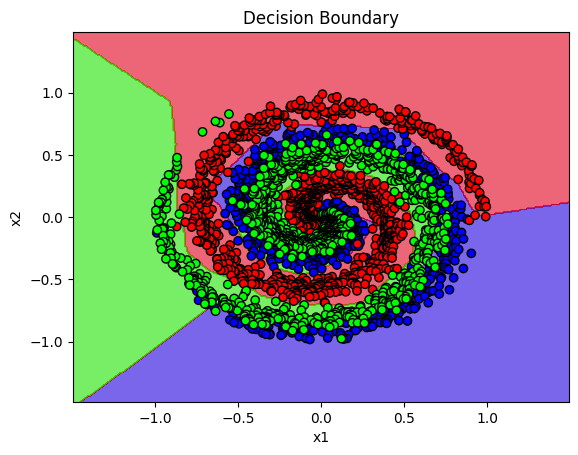

In [35]:
import matplotlib.pyplot as plt
import numpy as np

X , y = spiral_data(samples = 1000 , classes = 3)
dense1 = layer_dense(2,64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1= activation_reLU()
dropout1 = layer_dropout(0.05)
dense2=layer_dense(64,3)

loss_function= activation_softmax_loss_categoricalcrossentropy()

optimizer = optimizer_adam(learning_rate = 0.05 , decay = 5e-5 )

# Train in loop
for epoch in range(5001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.outputs)
    dense2.forward(dropout1.output)

    loss = loss_function.forward(dense2.output, y)
    regularization_loss = loss_function.loss.regularization_loss(dense1) + loss_function.loss.regularization_loss(dense2)
    final_loss = loss+ regularization_loss
    
    predictions = np.argmax(loss_function.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {final_loss:.3f} (' +
              f'data_loss: {loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(loss_function.output, y)
    dense2.backward(loss_function.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(dense1)
    optimizer.update_parameters(dense2)
    optimizer.post_update_parameters()

X_test, y_test = spiral_data(samples=100, classes=3)
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.outputs)
loss = loss_function.forward(dense2.output ,y_test)
predictions = np.argmax(loss_function.output, axis=1)
if len(y_test.shape) == 2:
 y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')



x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Forward pass on the grid
dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.outputs)
loss_function.activation.forward(dense2.output)

# Get predictions
predictions = np.argmax(loss_function.activation.output, axis=1)
predictions = predictions.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, predictions, cmap='brg', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()